# T2_Genetic Information Process Model(RDME)

Here we create a simple model includes the simple central metaoblism:

In [2]:
import jLM
from jLM.RegionBuilder import RegionBuilder
from jLM.RDME import Sim as RDMESim
from jLM.RDME import File as RDMEFile

from jLM.Solvers import makeSolver

import lm

from lm import IntMpdRdmeSolver

import os

import numpy as np

In [ ]:
totalTime = 30 #s
timeStep = 50e-6 #s
writeInterval = 2000 #s

In [3]:
# from pySTDLM import *
# from pyLM import *
from pyLM import LMLogger
LMLogger.setLMLogConsole()
#(logging.DEBUG)

In [4]:
lattice_spacing = 8e-9 #m

if lattice_spacing == 8e-9:
    
#     N_edges = [96, 96, 128] # Number of subvolumes making up and edge of the simulation space N x N x N
    N_edges = [64, 64, 64]

elif lattice_spacing == 10e-9:
    
    N_edges = [64, 64, 128]

sim_center = [int(N_edges[0]/2),int(N_edges[1]/2),int(N_edges[2]/2)]
N_2_x=int(N_edges[0]/2)
N_2_y=int(N_edges[1]/2)
N_2_z=int(N_edges[2]/2)

filename = 'nucleation_testing.lm'

In [5]:
sim = RDMESim("overflow_logging",
                  filename,
                  N_edges,
                  lattice_spacing,
                  "extracellular")

sim.timestep = timeStep
sim.simulationTime=totalTime
sim.latticeWriteInterval=writeInterval
sim.speciesWriteInterval=writeInterval

sim.transitionRate(None, None, None, sim.diffusionZero)

In [6]:
# def getDNAsites(DNAfile, N_edges,lattice_spacing):
# #     DNAfile needs to be bin
#     DNAsites = np.full((N_edges, N_edges, N_edges), False)
        
#     with open(DNAfile,'rb') as f:

#         DNAbin = np.fromfile(f,dtype=np.float64,count=-1)

#     DNAcoords = DNAbin.reshape((3,DNAbin.shape[0]//3),order='F').T

# #     print(DNAcoords.shape)
#     positions=[]
#     for DNAparticle in DNAcoords:

#         x = DNAparticle[0]
#         y = DNAparticle[1]
#         z = DNAparticle[2]

#         x_lattice = (x*1e-9)//(10*lattice_spacing)+N_edges/2
#         y_lattice = (y*1e-9)//(10*lattice_spacing)+N_edges/2
#         z_lattice = (z*1e-9)//(10*lattice_spacing)+N_edges/2

#         DNAsites[int(x_lattice),int(y_lattice),int(z_lattice)] = True
#         positions.append([int(x_lattice),int(y_lattice),int(z_lattice)])
#     return DNAsites ,positions

In [7]:
def getRibosomeSites(cytoplasm, N_edges):
    
    ribosome_centers = np.full((N_edges[0], N_edges[1], N_edges[2]), False)
    ribosomes = np.full((N_edges[0], N_edges[1], N_edges[2]), False)

    riboNum = 500
    
    cyto_coords = np.argwhere(cytoplasm==True)

    ribo_centers = []

    for i in range(riboNum):
        rand_Idx = np.random.randint(len(cyto_coords), size=1)[0]
        ribo_centers.append(cyto_coords[rand_Idx])
        cyto_coords = np.delete(cyto_coords, rand_Idx, 0)

    for center_point in ribo_centers:
        
        x_int = center_point[0]
        y_int = center_point[1]
        z_int = center_point[2]
        
        ribosomes[x_int,y_int,z_int] = True

        ribosomes[x_int+1,y_int,z_int] = True
        ribosomes[x_int-1,y_int,z_int] = True
        ribosomes[x_int,y_int+1,z_int] = True
        ribosomes[x_int,y_int-1,z_int] = True
        ribosomes[x_int,y_int,z_int+1] = True
        ribosomes[x_int,y_int,z_int-1] = True
    
    return ribosomes

In [8]:
def getDNAsites(DNAfile, N_edges):
    
#     DNAfile needs to be bin
    
    DNAsites = np.full((N_edges[0], N_edges[1], N_edges[2]), False)
        
    with open(DNAfile,'rb') as f:

        DNAbin = np.fromfile(f,dtype=np.float64,count=-1)

    DNAcoords = DNAbin.reshape((3,DNAbin.shape[0]//3),order='F').T

    print(DNAcoords.shape)

    for DNAparticle in DNAcoords:

        x = DNAparticle[0]
        y = DNAparticle[1]
        z = DNAparticle[2]

        x_lattice = (x*1e-9)//(10*lattice_spacing)+N_2_x
        y_lattice = (y*1e-9)//(10*lattice_spacing)+N_2_y
        z_lattice = (z*1e-9)//(10*lattice_spacing)+N_2_z

        DNAsites[int(x_lattice),int(y_lattice),int(z_lattice)] = True
        
    return DNAsites

In [9]:
radius_nm = 2.00e-7 #m minimal cell radius
cyto_radius = radius_nm/sim.latticeSpacing #m converted to lattice sites

In [10]:
build = RegionBuilder(sim)

cytoplasm = build.ellipsoid(radius = cyto_radius, center = sim_center)
cyto_dilation = build.dilate(cytoplasm, se = build.se26)
shell = cyto_dilation & ~cytoplasm
cyto_dilation = build.dilate(cyto_dilation, se = build.se26)
membrane = cyto_dilation & ~shell & ~cytoplasm

# cytoplasm = build.dilate(cytoplasm, se = build.se26)
# membrane  = build.dilate(cytoplasm, se = build.se26) & ~cytoplasm

DNAfile = './x_chain_syn3a_rep00001.bin'# DNA bin file

DNAsites = getDNAsites(DNAfile, N_edges)

cytoplasm = cytoplasm & ~DNAsites

ribosomes = getRibosomeSites(cytoplasm, N_edges)

extracellular = ~membrane & ~cytoplasm & ~ribosomes & ~DNAsites

build.compose(
    (sim.region('extracellular'), extracellular),
    (sim.region('cytoplasm'), cytoplasm),
    (sim.region('DNA'),DNAsites),
    (sim.region('ribosomes'), ribosomes),
    (sim.region('shell'), shell),
    (sim.region('membrane'), membrane))


(54338, 3)


In [11]:
diffRate=sim.diffusionConst("diffPtnCyt", 1e-12)
# sim.diffusionConst("diffPtnDna", 0.5e-12)

In [12]:
ext=sim.region('extracellular')
cyt=sim.region('cytoplasm')
dna=sim.region('DNA')
ribo=sim.region('ribosomes')
she=sim.region('shell')
mem=sim.region('membrane')

In [13]:
import itertools
def defineDiffusion(sim,regions,spc,rate):

    for reg in regions:
        spc.diffusionRate(reg,rate)
     
    for r1,r2 in itertools.permutations(regions,2):
        
        sim.transitionRate(spc, r1, r2, rate)
    
    return 

In [14]:
spcID='A'
mod=1
initN=500
comp_rate=10**6
for spcID in ['A','B','C','D','E']:
#     print(spcID,mod)
    print(spcID,comp_rate*mod)
    intermediates=['0','1']
    for x in range(2,4):
        intermediates.append(sim.species(spcID+str(x)))

    
    k1_rate=sim.rateConst('k1_'+spcID, comp_rate*mod, 2)
    k_rate=sim.rateConst('complexation_rate', comp_rate, 2)
    
    spc=sim.species(spcID)
    sim.distributeNumber(spc,sim.region('cytoplasm'),initN)
#     defineDiffusion(sim,[mem,cyt,she,dna],spc,diffRate)

#     for x in intermediates[2:]:
#         defineDiffusion(sim,[mem,cyt,she,dna],x,diffRate)

    for reg in cyt,mem,she,dna:
        reg.addReaction([spc,spc],[intermediates[2]],k1_rate)
        for i in range(2,3):
            reg.addReaction([spc,intermediates[i]],[intermediates[i+1]],k_rate)
    mod=mod/10

A 1000000
B 100000.0
C 10000.0
D 1000.0
E 100.0


Time step,50.000 µs
Simulation time,30.000 s
Lattice write interval,2.000 × 103 s
Particle count write interval,2.000 × 103 s
Dimensions,64 × 64 × 64
Particles per site,16
Bytes per particle,4
Lattice spacing,8.000 nm
Subvolume size,5.120 × 10-7 fl
Output file,nucleation_testing.lm
Number of species,15

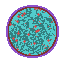

In [15]:
sim

In [16]:
# sim.displayGeometry()

In [17]:
sim.showSpecies('A')

In [18]:
sim.finalize()

2024-04-25 17:46:22) Info: Using 32 processor(s) and 1 CUDA device(s) per process.
2024-04-25 17:46:22) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2024-04-25 17:46:22) Info: Data output thread running.
2024-04-25 17:46:23) Info: Time is 0.10000000000000
2024-04-25 17:46:23) Info: Lattice write time is 0.10000000000000, in steps is 2000
2024-04-25 17:46:23) Info: Next lattice write time is 4000
2024-04-25 17:46:24) Info: Time is 0.20000000000000
2024-04-25 17:46:24) Info: Lattice write time is 0.20000000000000, in steps is 4000
2024-04-25 17:46:24) Info: Next lattice write time is 6000
2024-04-25 17:46:25) Info: Time is 0.30000000000000
2024-04-25 17:46:25) Info: Lattice write time is 0.30000000000000, in steps is 6000
2024-04-25 17:46:25) Info: Next lattice write time is 8000
2024-04-25 17:46:26) Info: Time is 0.40000000000000
2024-04-25 17:46:26) Info: Lattice write time is 0.40000000000000, in steps is 8000
2024-04-25 17:46:26) Info: Next lattice write t


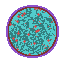

In [19]:
sim.run(solver=IntMpdRdmeSolver(), cudaDevices=[1])

In [20]:
import matplotlib.pyplot as plt

In [21]:
traj = RDMEFile(filename,replicate=1)
times= traj.speciesCountTimes
# print(times)
# print(times[-1],times[-1]/60)
# times=np.arange(0,simTime+1)
times=times/60.0 #convert to mins
simTime=int(times[-1])
print(simTime,'mins')
simTime=simTime*60
sL= [x.name for x in traj.speciesList]
sL

0 mins


['A2',
 'A3',
 'A',
 'B2',
 'B3',
 'B',
 'C2',
 'C3',
 'C',
 'D2',
 'D3',
 'D',
 'E2',
 'E3',
 'E']

In [22]:
traces=np.zeros((len(sL),len(times)))

for i,s in enumerate(sL):
        t,trace=traj.getNumberTrajectory(species = traj.species(s))
        traces[i]=trace

A
B
C
D
E


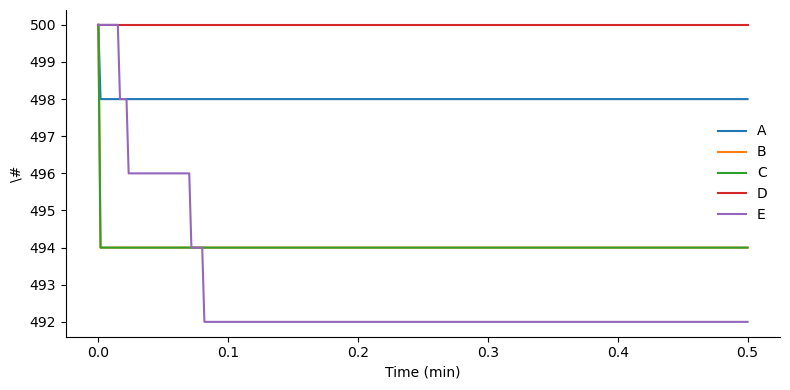

In [23]:
fig,ax=plt.subplots(1,figsize=(8,4))

for spcID in ['A','B','C','D','E']:
    print(spcID)
    plt.plot(times,traces[sL.index(spcID)],label=spcID)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time (min)')
ax.set_ylabel('\#')
plt.legend().get_frame().set_alpha(0)
plt.tight_layout()
plt.show()

A3 0.0
B3 0.0
C3 0.0
D3 0.0
E3 0.0


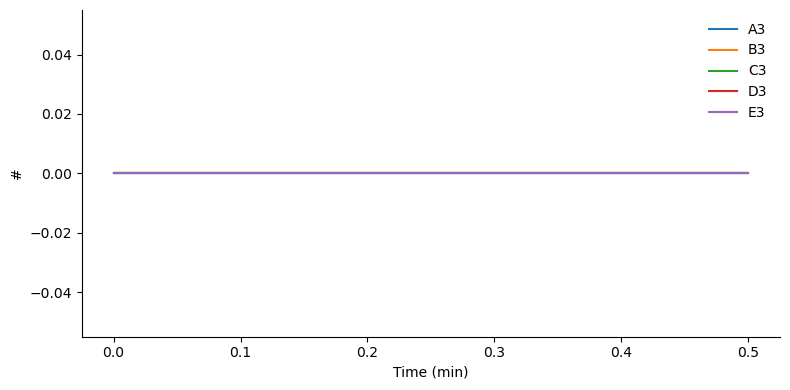

In [24]:
fig,ax=plt.subplots(1,figsize=(8,4))

for spcID in ['A','B','C','D','E']:
    spcID=spcID+'3'
    print(spcID,traces[sL.index(spcID)][-1]/initN)
    
    plt.plot(times,traces[sL.index(spcID)],label=spcID)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time (min)')
ax.set_ylabel('#')
plt.legend().get_frame().set_alpha(0)
plt.tight_layout()
plt.show()